In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from random import shuffle
import train
import imp
import os
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
%matplotlib inline


In [33]:
map_characters ={0:'CarolinaChickadee' , 1:'EmptyFeeder',2:'EuropeanStarling',3:'GrayCatbird',4:'NorthernCardinal',5:'RedBelliedWoodpecker',6:'TuftedTitmouse',7:'YellowRumpedWarbler'}


In [34]:
imp.reload(train)
X_train, X_test, y_train, y_test = train.get_dataset(save=True)

433
563
854
964
1922
974
343
999
Train (5994, 140, 140, 3) (5994, 8)
Test (1058, 140, 140, 3) (1058, 8)
NorthernCardinal : 1631 train pictures & 291 test pictures
YellowRumpedWarbler : 870 train pictures & 129 test pictures
RedBelliedWoodpecker : 829 train pictures & 145 test pictures
GrayCatbird : 817 train pictures & 147 test pictures
EuropeanStarling : 700 train pictures & 154 test pictures
EmptyFeeder : 487 train pictures & 76 test pictures
CarolinaChickadee : 380 train pictures & 53 test pictures
TuftedTitmouse : 280 train pictures & 63 test pictures


In [35]:

# X_train, X_test, y_train, y_test = train.get_dataset()
# model, opt = train.create_model_four_conv(X_train.shape[1:])
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model, history = train.training(model, X_train, X_test, y_train, y_test, data_augmentation=True, callback=True, six_conv=True)

## Training on AWS
# X_train, X_test, y_train, y_test = train.get_dataset(load=True)
# model = keras.models.load_model('./models/model_08_06.h5')

    
## Loading from callbacks

imp.reload(train)
model = train.load_model_from_checkpoint('weight test2 for 6 convolutionslayers-033-0.0955-0.9754.hdf5', six_conv=True)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')




                      precision    recall  f1-score   support

   CarolinaChickadee       0.87      0.77      0.82        53
         EmptyFeeder       1.00      1.00      1.00        76
    EuropeanStarling       0.97      0.99      0.98       154
         GrayCatbird       1.00      0.99      1.00       147
    NorthernCardinal       1.00      0.99      0.99       291
RedBelliedWoodpecker       1.00      0.99      1.00       145
      TuftedTitmouse       0.84      0.86      0.85        63
 YellowRumpedWarbler       0.93      0.98      0.95       129

         avg / total       0.97      0.97      0.97      1058



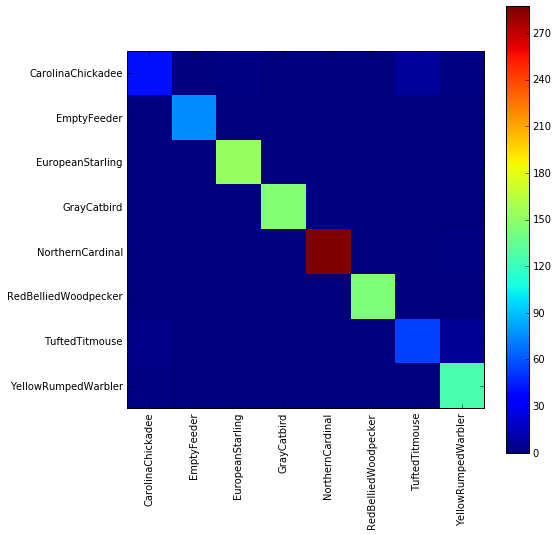

In [37]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

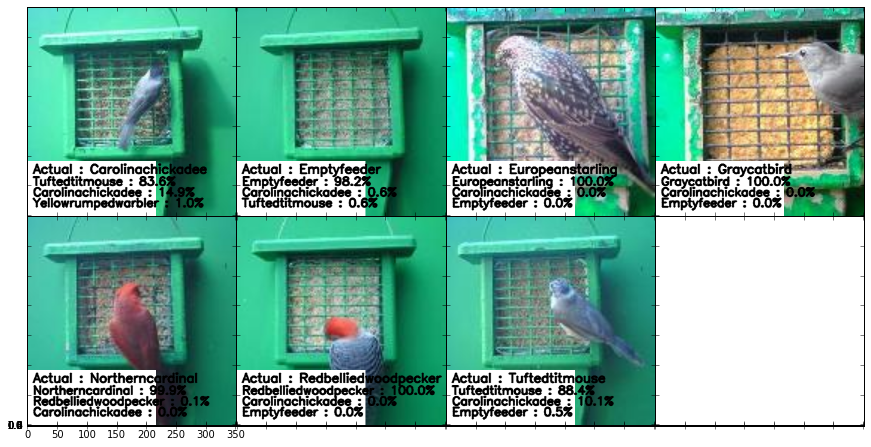

In [41]:
from mpl_toolkits.axes_grid1 import AxesGrid
map_characters = map_characters ={0:'CarolinaChickadee' , 1:'EmptyFeeder',2:'EuropeanStarling',3:'GrayCatbird',4:'NorthernCardinal'
                                  , 5:'RedBelliedWoodpecker',6:'TuftedTitmouse',7:'YellowRumpedWarbler'}

F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111,  # similar to subplot(141)
                nrows_ncols=(3, 4),
                axes_pad=0,
                label_mode="1")

for i in range(7):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('./data3/%s/*' % char)]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (140, 140)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 140, 140,3))[0]
    actual = char.split('_')[0].title()
#     pred = map_characters[np.argmax(a)].split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
#     cv2.putText(img, 'Pred : %s' % pred, (100, 310), font, 0.7,(0,0,0),2,cv2.LINE_AA)    
    grid[i].imshow(img)

In [45]:
y_pred = model.predict(X_test, verbose=0)
comp = np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1)
index_good, index_false = [i for i, x in enumerate(comp) if x], [i for i, x in enumerate(comp) if not x]



In [46]:
max_good = np.max(y_pred[index_good], axis=1)
max_wrong = np.max(y_pred[index_false], axis=1)
diff_good = np.diff(np.sort(y_pred[index_good], axis=1)[:, 16:])
diff_wrong = np.diff(np.sort(y_pred[index_false], axis=1)[:, 16:])
std_good = np.std(y_pred[index_good], axis=1)
std_wrong = np.std(y_pred[index_false], axis=1)

print("For good predictions : Max : {:.2f}, Difference Two First : {:.3f}, STD : {:.2f}".format(np.mean(max_good),
                                                                            np.mean(diff_good),
                                                                            np.mean(std_good)))
print("For wrong predictions : Max : {:.2f}, Difference Two First : {:.3f}, STD : {:.2f}".format(np.mean(max_wrong),
                                                                             np.mean(diff_wrong),
                                                                            np.mean(std_wrong)))

For good predictions : Max : 0.97, Difference Two First : nan, STD : 0.32
For wrong predictions : Max : 0.68, Difference Two First : nan, STD : 0.23


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [47]:

indices = [round(k*0.01,2) for k in range(0, 100, 5)] + [0.99]
pos_characters = {cl: {k:[] for k in indices} for cl in map_characters}
for k in indices:
    for i, e in enumerate(y_pred):
        if np.max(e) > k:
            pos_characters[np.argmax(e)][k].append(int(np.argmax(e) == np.argmax(y_test[i])))
pos_characters['ALL'] = {k:np.sum([pos_characters[cl][k] for cl in pos_characters]) for k in indices}

In [53]:
indices = [round(k*0.01, 2)+round(p*0.01,2) for k,p in zip(range(0, 20), range(0, 100, 5))]
pos_characters_2 = {cl: {k:[] for k in indices} for cl in map_characters}
for k in indices:
    for i, e in enumerate(y_pred):
        if np.std(e)+np.max(e) > k:
            pos_characters_2[np.argmax(e)][k].append(int(np.argmax(e) == np.argmax(y_test[i])))
pos_characters_2['ALL'] = {k:np.sum([pos_characters_2[cl][k] for cl in pos_characters_2]) for k in indices}

KeyError: 0.060000000000000005

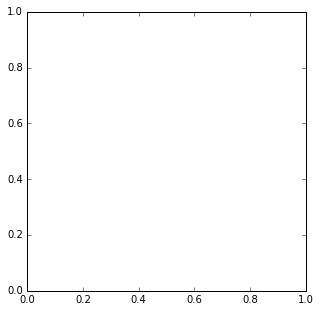

In [54]:
classes_plot = ["ALL"]
tr = {"ALL": np.argmax(y_test, axis=1)}
f, ax = plt.subplots(ncols=len(classes_plot), figsize=(len(classes_plot)*5, 5))
for i, cl_plt in enumerate(classes_plot):
    precision = {k:np.sum(pos_characters[cl_plt][k])/len(pos_characters[cl_plt][k]) for k in indices}
    recall = {k:np.sum(pos_characters[cl_plt][k])/np.sum(np.argmax(y_test, axis=1)==tr.get(cl_plt, cl_plt))for k in indices}
    f1_score = {k:(2*precision[k]*recall[k])/(precision[k]+recall[k]) for k in indices}
    x,y = zip(*sorted(precision.items()))
    ax[i].plot(x, y, color='blue', label='Precision')
    x,y = zip(*sorted(recall.items()))
    ax[i].plot(x, y, label='Recall', color='green')
    x,y = zip(*sorted(f1_score.items()))
    ax[i].plot(x, y, color='red', label='F1 Score')
    _ = ax[i].set_xlim((0,1))
    _ = ax[i].set_ylabel('Score')
    _ = ax[i].set_xlabel('Threshold (Probability minimum for predicted class)')
    _ = ax[i].set_ylim((0.3,1))
    _ = ax[i].legend()
    _ = ax[i].set_title('Class : %s \n(Test set size : %d)' % (map_characters.get(cl_plt, cl_plt), np.sum(np.argmax(y_test, axis=1) == tr.get(cl_plt, cl_plt))))

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


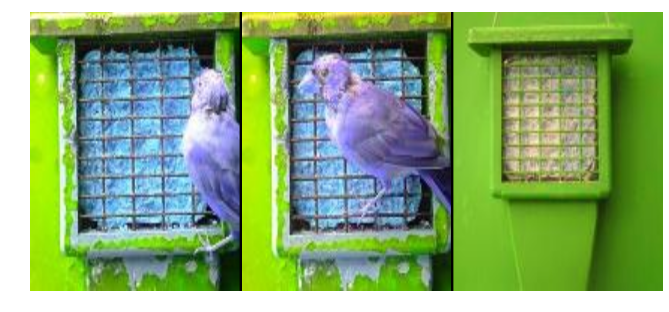

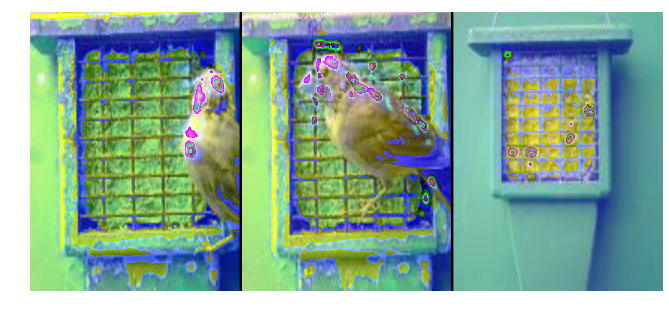

In [55]:

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
from vis.visualization import visualize_saliency

# The name of the layer we want to visualize
layer_idx = [idx for idx, layer in enumerate(model.layers)][16]

# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = np.random.choice(np.concatenate([glob.glob('./data3/%s/*.jpg' % k) for k in map_characters.values()]), 3)

heatmaps = []
true_img = []
d=[]
for path in image_paths:
    seed_img = utils.load_img(path, target_size=(140, 140)).astype('float32') / 255.
    seed_img  = seed_img.reshape((1, 140, 140, 3))
    pred_class = np.argmax(model.predict(seed_img))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    heatmap = visualize_saliency(model, layer_idx, [pred_class], seed_img.reshape((140, 140, 3)))
    heatmaps.append(heatmap * 255.) 
    true_img.append(cv2.resize(cv2.imread(path),(480,640)))
    d.append(cv2.resize(cv2.imread(path),(480,640)) + cv2.resize(heatmap,(480,640)))

plt.figure(figsize=(14,5))
plt.axis('off')
plt.imshow(utils.stitch_images(true_img))
plt.show()

plt.figure(figsize=(14,5))
plt.axis('off')
plt.imshow(utils.stitch_images(d))
plt.show()